# Data Reduction by Aggregation

> Hands‑on demo to accompany the slide **‘Data Reduction by Aggregation’**.

**What you will learn**
- Why we aggregate (reduce volume, simplify patterns)
- Common aggregation patterns: time resampling, group‑by rollups, pivot tables
- Choosing functions (sum, mean, min/max, count, median) and custom aggregations
- Rolling windows (moving averages) vs. downsampling
- Trade‑offs: information loss vs. clarity and speed


## 0. Setup (packages)
Run this once in VS Code to install dependencies.

In [1]:
#%pip -q install numpy pandas matplotlib seaborn scikit-learn

## 1. Imports & reproducibility

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

np.random.seed(42)
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = (10,4)

## 2. Concept — What is aggregation?
**Aggregation** reduces data volume by summarizing many rows into fewer rows using functions like `sum`, `mean`, `count`, and percentiles.

**Why aggregate?**
- Make trends visible (less noise).
- Reduce storage/compute costs.
- Prepare features for models that prefer lower granularity.

**Trade‑off:** Every aggregation throws away detail. Pick levels that keep the signal you need.

## 3. Create a minute‑level time series (simulated)
We’ll create 90 days of **minute** measurements for a metric like `visits` and a second metric `revenue` with daily cycles and noise.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Minute-level index for 90 days
rng = pd.date_range('2025-01-01', periods=90*24*60, freq='min')  # robust alias

# --- Use arrays instead of Index to avoid Index-propagation ---
h = rng.hour.to_numpy()      # hours as ndarray
m = rng.minute.to_numpy()    # minutes as ndarray

# Daily rhythm (smooth sinusoid)
base = 20 + 10*np.sin(2*np.pi*(h*60 + m)/(24*60))

# Simulated metrics
visits = np.random.poisson(lam=np.maximum(base, 0.1))

# Use the array hours for the revenue cycle too
revenue = visits * (2 + 0.5*np.sin(2*np.pi*h/24) + np.random.normal(0, 0.2, len(rng)))
revenue = np.clip(revenue, 0, None)   # np.clip works on ndarrays

# Build DataFrame
df = pd.DataFrame({'timestamp': rng, 'visits': visits, 'revenue': revenue})
df = df.set_index('timestamp')

df.head()

,visits,revenue
timestamp,,
2025-01-01 00:00:00,23,39.974473
2025-01-01 00:01:00,15,28.051447
2025-01-01 00:02:00,21,47.757233
2025-01-01 00:03:00,25,45.756952
2025-01-01 00:04:00,15,27.699705


### Plot a 3‑day sample (minute‑level)

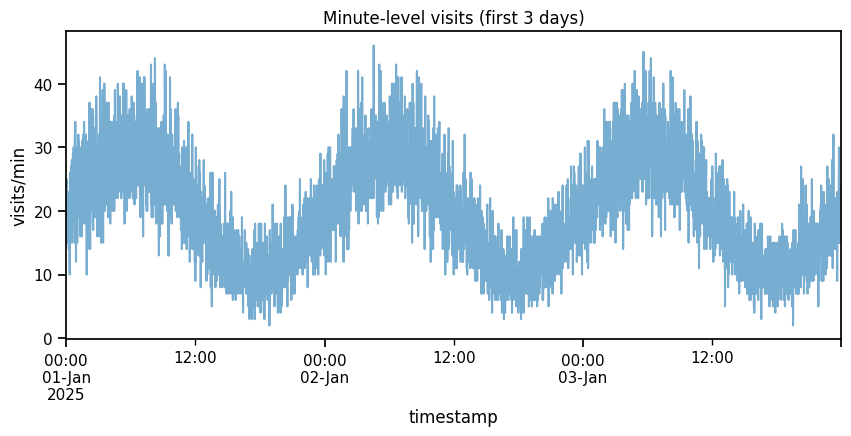

In [4]:
sample = df.iloc[:3*24*60]
ax = sample['visits'].plot(alpha=0.6, title='Minute‑level visits (first 3 days)')
ax.set_ylabel('visits/min'); plt.show()

## 4. Time **resampling** (downsampling): minute → hour → day
Resampling with `DataFrame.resample` groups by fixed time windows. We’ll compute **mean visits** and **sum revenue** per window.

C:\Users\Eespinosa\AppData\Local\Temp\ipykernel_23932\3646997721.py:7: Pandas4Warning: 'd' is deprecated and will be removed in a future version, please use 'D' instead.
  daily = df.resample('1d').agg(


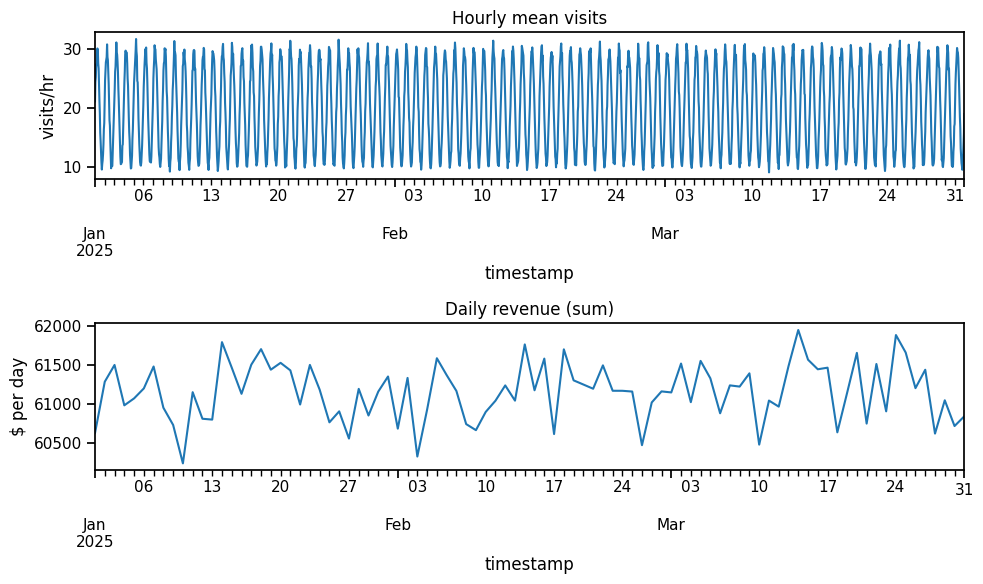

,visits_mean,revenue_sum
timestamp,,
2025-01-01 00:00:00,21.133333,2551.046284
2025-01-01 01:00:00,24.450000,3085.150012
2025-01-01 02:00:00,25.250000,3340.012739
2025-01-01 03:00:00,27.450000,3850.672313
2025-01-01 04:00:00,27.283333,3985.852417


In [5]:
# Hourly and daily aggregations — use lowercase or explicit increments
hourly = df.resample('1h').agg(
    visits_mean=('visits', 'mean'),
    revenue_sum=('revenue', 'sum')
)

daily = df.resample('1d').agg(
    visits_mean=('visits', 'mean'),
    revenue_sum=('revenue', 'sum')
)

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=False)
hourly['visits_mean'].plot(ax=axes[0], title='Hourly mean visits')
daily['revenue_sum'].plot(ax=axes[1], title='Daily revenue (sum)')
axes[0].set_ylabel('visits/hr'); axes[1].set_ylabel('$ per day')
plt.tight_layout(); plt.show()

hourly.head()

## 5. Group‑by rollups (categorical aggregation)
Let’s add a **store** and **channel** attribute and aggregate revenue by them.

<Axes: title={'center': 'Revenue by store (hourly→sum)'}, xlabel='store'>

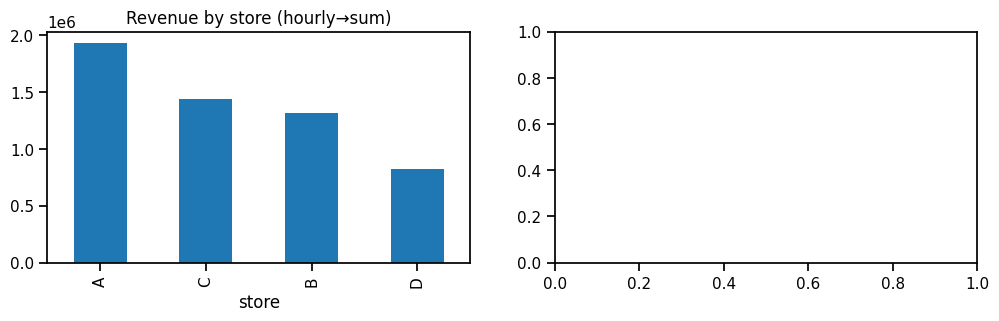

In [6]:
# --- Add categorical attributes ---
stores   = np.random.choice(['A','B','C','D'], size=len(df), p=[0.35, 0.25, 0.25, 0.15])
channels = np.random.choice(['web','app','store'], size=len(df), p=[0.50, 0.30, 0.20])

df2 = df.copy()
df2['store']   = stores
df2['channel'] = channels

# --- Aggregate to hourly by store and channel ---
# Use lowercase or explicit increments for the resampling frequency
hourly_roll = (
    df2.resample('1h').sum(numeric_only=True)                # sums for numeric columns (visits, revenue)
       .join(df2[['store','channel']].resample('1h').last()) # carry last label seen in the hour window
)

rev_by_store   = hourly_roll.groupby('store')['revenue'].sum().sort_values(ascending=False)
rev_by_channel = hourly_roll.groupby('channel')['revenue'].sum().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
rev_by_store.plot(kind='bar',   ax=axes[0], title='Revenue by store (hourly→sum)')


## 6. Pivot tables for quick summaries
Pivot tables combine grouping + aggregation + reshape.

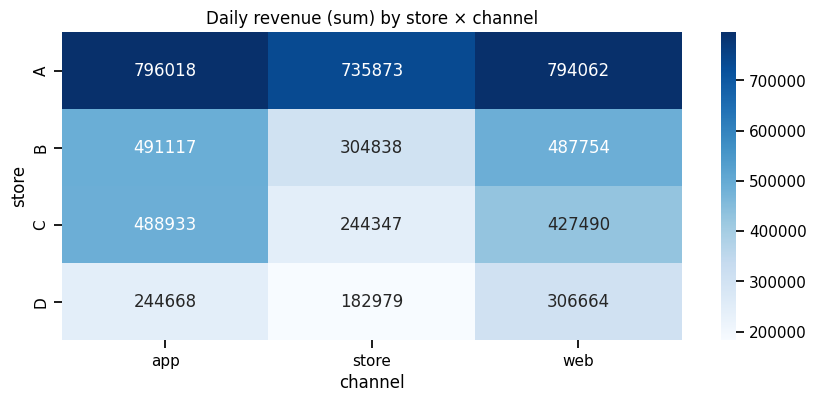

channel,app,store,web
store,,,
A,796018.0,735873.0,794062.0
B,491117.0,304838.0,487754.0
C,488933.0,244347.0,427490.0
D,244668.0,182979.0,306664.0


In [7]:
# Daily revenue by store × channel
daily_sc = df2.resample('D').sum(numeric_only=True).join(df2[['store','channel']].resample('D').last())
pivot = pd.pivot_table(daily_sc, values='revenue', index='store', columns='channel', aggfunc='sum')
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='Blues'); plt.title('Daily revenue (sum) by store × channel'); plt.show()
pivot.round(0)

## 7. Rolling windows (moving averages) vs. downsampling
Rolling windows smooth noise **without** reducing the number of timestamps. Downsampling reduces rows.

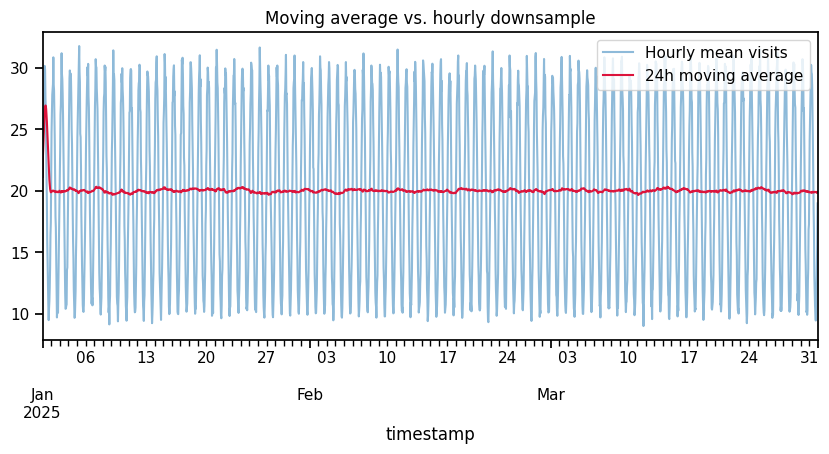

In [9]:
# Downsample to hourly series (lowercase / explicit increments)
d1 = df['visits'].resample('1h').mean()          # or .resample('h').mean()

# 24-hour moving average on the hourly series
ma_24h = d1.rolling(window=24, min_periods=1).mean()

# Plot
fig, ax = plt.subplots()
d1.plot(ax=ax, alpha=0.5, label='Hourly mean visits')
ma_24h.plot(ax=ax, color='crimson', label='24h moving average')
ax.set_title('Moving average vs. hourly downsample')
ax.legend()
plt.show()

## 8. Does aggregation hurt a prediction task?
We’ll predict **daily revenue** from **daily visits** using linear regression and compare the fit after aggregating minute data to daily.

In [10]:
daily = df.resample('D').agg(visits_sum=('visits','sum'), revenue_sum=('revenue','sum'))
X = daily[['visits_sum']].values; y = daily['revenue_sum'].values
model = LinearRegression().fit(X, y)
pred = model.predict(X)
r2 = r2_score(y, pred)
r2, model.coef_, model.intercept_

(0.7567493792128784, array([2.10655558]), np.float64(491.9024776528895))

**Interpretation:** With a sensible aggregation (sum of visits per day), the model captures a strong relationship to daily revenue. If we tried to learn on minute‑level rows, training would be slower and the relationship would be noisier without additional features.

## 9. Custom aggregations
You can pass multiple functions per column or your own callable.

In [11]:
custom = df.resample('D').agg(visits_sum=('visits','sum'), visits_p95=('visits', lambda s: s.quantile(0.95)),
                            rev_sum=('revenue','sum'), rev_median=('revenue','median'))
custom.head()

,visits_sum,visits_p95,rev_sum,rev_median
timestamp,,,,
2025-01-01,28631,34.0,60633.295009,38.168664
2025-01-02,28817,34.0,61290.496522,39.451946
2025-01-03,28863,34.0,61505.408042,39.323749
2025-01-04,28820,35.0,60988.232484,39.192494
2025-01-05,28781,35.0,61076.939755,38.163045


## 10. Practical checklist
- Match the **aggregation function** to the question (e.g., sum for totals, mean for levels, median for robustness).
- Keep the **grain** consistent across training vs. inference.
- Document your **resampling rules** (window size, alignment) to avoid silent mismatches.
- Consider **percentiles** or **robust stats** when outliers exist.
- For very large datasets, compute aggregates in the database/warehouse and load summarized tables into Python.

## 11. Practice exercises
1. Aggregate to **weekly** and compare patterns vs. daily.
2. Add a new metric (e.g., `conversions`) and compute daily **conversion rate** from sums.
3. Try a **7‑day moving median** and compare with the moving average.
4. Build a small helper `aggregate_time(df, rule, specs)` that applies multiple aggregations in one call.
5. (Challenge) Using hourly data, engineer features (mean, p95, min) for the past 24h to predict tomorrow’s revenue.

---
_Last updated: 2026-02-17 21:05:07 UTC_
